In [1]:
from config import*
from SPP_AD import*
from Model import*
from NTK import *

/envs/common/lib/python3.12/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


family_len:  3079


In [2]:
PINN_model = PINN(input_size = n_collocation, 
                    num_hidden_layers = 6, 
                    hidden_neurons = 100).to(device)

optimizer = optim.Adam(PINN_model.parameters(), lr=1e-5)

In [3]:
x_interior = x_collocation.clone().requires_grad_(True)

def pinn_loss():   

    u = PINN_model(x_interior)
    u_x = torch.autograd.grad(u, x_interior, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    u_pred_bc_left = PINN_model(x_bc_left)
    u_pred_bc_right = PINN_model(x_bc_right)
    
    pde_loss = torch.mean((e*u_xx + (1+e)*u_x + u) ** 2)    

    bc_loss = torch.mean((u_pred_bc_left - u_bc_left) ** 2) + \
              torch.mean((u_pred_bc_right - u_bc_right) ** 2)
    
    total_loss = pde_loss + bc_loss
    
    return total_loss, pde_loss, bc_loss


NTK_PINN = []
itr = [0, 1000, 10000, 50000]

def train_wpinn(num_epochs, num_prints):

    for epoch in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        total_loss, pde_loss, bc_loss = pinn_loss()
        
        total_loss.backward()
        optimizer.step()

        # if epoch in itr: NTK_PINN.append(PINN_NTK(PINN_model))
    
        if epoch % ((num_epochs-1)/num_prints) == 0:  # Print every num_prints epochs
            
            with torch.no_grad():
                numerical = PINN_model(x_validation.to(device)).cpu()
                errL2 = (torch.sum(torch.abs(exact-numerical)**2))**0.5 / (torch.sum(torch.abs(exact)**2))**0.5
                errMax = torch.max(torch.abs(exact-numerical))

            print(f'Epoch [{epoch}/{num_epochs}], '
                f'Total Loss: {total_loss.item():.6f}, '
                f'PDE Loss: {pde_loss.item():.6f}, '
                f'BC Loss: {bc_loss.item():.6f}\n\t\t'
                f'RelativeL2: {errL2},\t\t'
                f'Max: {errMax}\n' )
            
        torch.cuda.empty_cache()

In [4]:
num_epochs = 5*10**4+1
num_prints = 5
train_wpinn(num_epochs, num_prints)

  0%|          | 0/50001 [00:00<?, ?it/s]/envs/common/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 35/50001 [00:00<04:20, 191.51it/s]

Epoch [0/50001], Total Loss: 0.710281, PDE Loss: 0.232150, BC Loss: 0.478132
		RelativeL2: 28.9654598236084,		Max: 2.5950043201446533



 20%|██        | 10046/50001 [00:35<02:23, 278.37it/s]

Epoch [10000/50001], Total Loss: 0.633602, PDE Loss: 0.183118, BC Loss: 0.450484
		RelativeL2: 27.14971923828125,		Max: 2.374401569366455



 40%|████      | 20048/50001 [01:10<01:47, 277.74it/s]

Epoch [20000/50001], Total Loss: 0.633597, PDE Loss: 0.183137, BC Loss: 0.450460
		RelativeL2: 27.14995765686035,		Max: 2.3744027614593506



 60%|██████    | 30052/50001 [01:45<01:10, 284.55it/s]

Epoch [30000/50001], Total Loss: 0.633593, PDE Loss: 0.183100, BC Loss: 0.450494
		RelativeL2: 27.150291442871094,		Max: 2.3744051456451416



 80%|████████  | 40025/50001 [02:20<00:45, 219.12it/s]

Epoch [40000/50001], Total Loss: 0.633588, PDE Loss: 0.183554, BC Loss: 0.450034
		RelativeL2: 27.151391983032227,		Max: 2.3744075298309326



100%|██████████| 50001/50001 [02:55<00:00, 285.14it/s]

Epoch [50000/50001], Total Loss: 0.633568, PDE Loss: 0.183179, BC Loss: 0.450388
		RelativeL2: 27.15081024169922,		Max: 2.3744583129882812



In [ ]:
# Save NTK eigen values
file_name = "PINN_ntk.csv" 
np.savetxt(file_name, NTK_PINN, delimiter=",")

RelativeL2: 85.73634338378906,		 Max: 2.3746259212493896



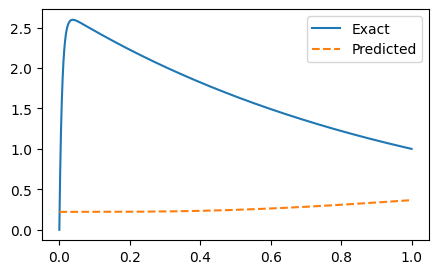

In [5]:
# Testing and Plotting
u_pred = PINN_model(x_test.to(device)).cpu().detach().numpy()
errL2 = (np.sum(np.abs(u_exact-u_pred)**2))**0.5 / (np.sum(np.abs(u_exact)**2))**0.5
errMax = np.max(np.abs(u_exact-u_pred))

print(f'RelativeL2: {errL2},\t\t', f'Max: {errMax}\n' )


fig = plt.figure(figsize=(5,3))
plt.plot(x_test, u_exact, label='Exact')
plt.plot(x_test, u_pred, '--', label='Predicted')
plt.legend()
plt.show()
